In [1]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 17.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 9.7 MB/s eta 0:00:00


In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torchinfo import summary
import mlflow
from torch.utils.data import Subset

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("inceptionv3-tomato")

MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=inceptionv3-tomato (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x785daf1d97e0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [8]:
import gc
gc.collect()

3556

In [9]:
def tv_split(dataset,split_size=0.25):
    print(len(dataset))
    train_idx, val_idx = torch.utils.data.random_split(dataset,[25787,64])
    datasets = {}
    print(train_idx)
    datasets['train'] = train_idx
    datasets['validation'] = val_idx
    return datasets

In [33]:
transform = transforms.Compose([transforms.Resize((300,300)), transforms.ToTensor(), transforms.RandomHorizontalFlip()])
traindata = datasets.ImageFolder("/kaggle/input/tomato/train", transform=transform)
validdata = datasets.ImageFolder("/kaggle/input/tomato/valid", transform=transform)

# dataset = tv_split(traindata)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=60, shuffle=True)
validationloader = torch.utils.data.DataLoader(validdata, batch_size=60, shuffle=True)

loader = {'train':trainloader, 'validation':validationloader}

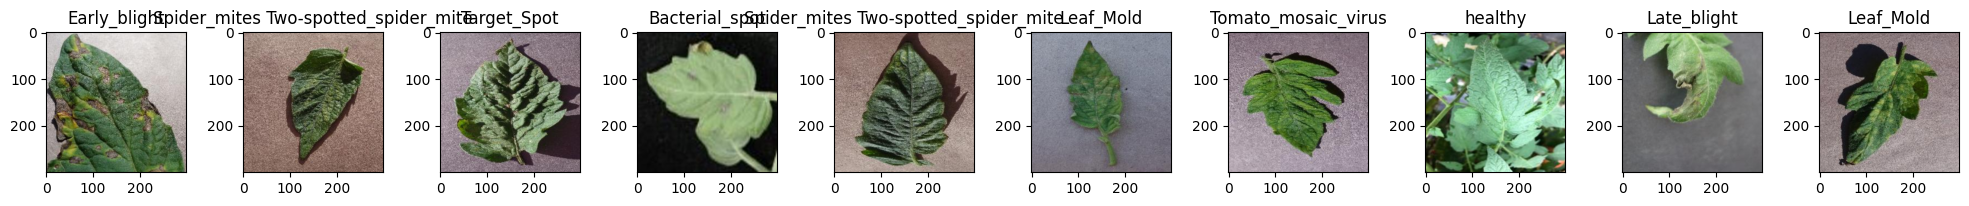

In [35]:
def im_convert(tensor):
  img = tensor.clone().detach().numpy()
  img  = img.transpose(1,2,0)
  # img = img*np.array(([0.485, 0.456, 0.406])/np.array(([0.229, 0.224, 0.225])))
  return img

dataiter = iter(validationloader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25,4))
for i in np.arange(10):
  ax = fig.add_subplot(2,10, i+1)
  plt.imshow(im_convert(images[i]))
  ax.set_title(traindata.classes[labels[i].item()])

In [12]:
model = models.inception_v3(pretrained=False);

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [13]:
in_features = model.fc.in_features
model.fc=nn.Linear(in_features, len(traindata.classes))
model = model.to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [15]:
running_loss_history = []
val_running_loss_historu = []

running_loss_correct = []
val_running_loss_correct = []
epochs = 20

def train(model, epochs=20):
  for i in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0

    running_correct = 0.0
    val_running_correct = 0.0

    for inputs, labels in trainloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs,_ = model(inputs)
      optimizer.zero_grad()
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      _,pred = torch.max(outputs,1)
      running_correct+=torch.sum(pred==labels.data)

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validationloader:
          val_inputs,val_labels = val_inputs.to(device), val_labels.to(device)
          val_outputs,_ = model(val_inputs)
          val_loss = loss_fn(val_outputs, val_labels)
          _,val_pred = torch.max(val_outputs,1)
          val_running_correct+=torch.sum(val_pred==val_labels.data)
          val_running_loss+=val_loss.item()

      val_epoch_accuracy = val_running_correct.float()/len(validationloader.dataset)
      val_epoch_loss = val_running_loss/len(validationloader.dataset)
      val_running_loss_historu.append(val_epoch_loss)
      val_running_loss_correct.append(val_epoch_accuracy)

      epoch_accuracy = running_correct.float()/len(trainloader.dataset)

      epoch_loss = running_loss/len(trainloader.dataset)
      running_loss_history.append(epoch_loss)
      running_loss_correct.append(epoch_accuracy)

      print("Epoch:{}".format(i))
      print("Training loss:{} and Accuracy:{}".format(epoch_loss, epoch_accuracy.item()))
      print("Validation loss: {} and Accuracy:{}".format(val_epoch_loss, val_epoch_accuracy.item()))

In [16]:
# with mlflow.start_run() as run:
#     params = {
#         "epochs":epochs,
#         "learning_rate":1e-3,
#         "batch_size":60,
#         "loss_function": loss_fn.__class__.__name__,
#         "optimizer": "SGD",
#     }
#     mlflow.log_params(params)
#     with open("model_summary.txt", "w",encoding="utf-8") as f:
#         f.write(str(summary(model)))
#     mlflow.log_artifact("model_summary.txt")
train(model, 10)
    # mlflow.pytorch.log_model(model, "model")    


Epoch:0
Training loss:0.035093129061623325 and Accuracy:0.25697264075279236
Validation loss: 0.04530741300444465 and Accuracy:0.10100254416465759
Epoch:1
Training loss:0.026368437143161786 and Accuracy:0.46245792508125305
Validation loss: 0.05239074083568271 and Accuracy:0.10459374636411667
Epoch:2
Training loss:0.02102237544868224 and Accuracy:0.565471351146698
Validation loss: 0.057500686863841154 and Accuracy:0.11102798581123352
Epoch:3
Training loss:0.017868769601864176 and Accuracy:0.6329735517501831
Validation loss: 0.06078305348617917 and Accuracy:0.10728714615106583
Epoch:4
Training loss:0.015880907378728503 and Accuracy:0.6744033098220825
Validation loss: 0.06316634089972076 and Accuracy:0.11446955054998398
Epoch:5
Training loss:0.014362594105188291 and Accuracy:0.706200897693634
Validation loss: 0.06431131669366572 and Accuracy:0.11102798581123352
Epoch:6
Training loss:0.013002865153361343 and Accuracy:0.7338207364082336
Validation loss: 0.06608246875776068 and Accuracy:0.106

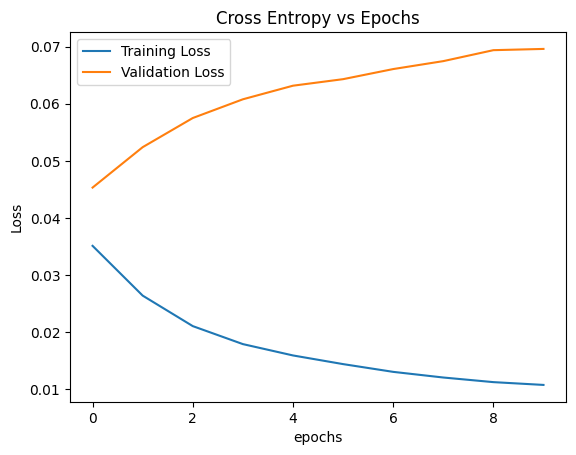

In [17]:
plt.plot(running_loss_history, label = "Training Loss")
plt.plot(val_running_loss_historu, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Cross Entropy vs Epochs")
plt.legend()

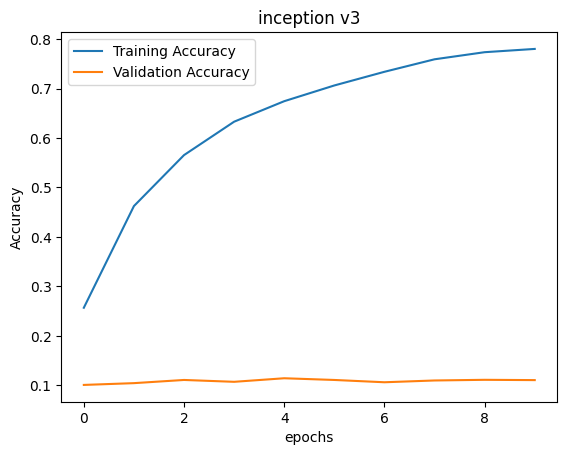

In [18]:
running_loss_correct = [i.cpu() for i in running_loss_correct]
val_running_loss_correct = [i.cpu() for i in val_running_loss_correct]
plt.plot(running_loss_correct, label = "Training Accuracy")
plt.plot(val_running_loss_correct, label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("inception v3")
plt.legend()

In [19]:
torch.save(model, './inceptionV3_tomato.pth')

In [26]:
classes = traindata.classes


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


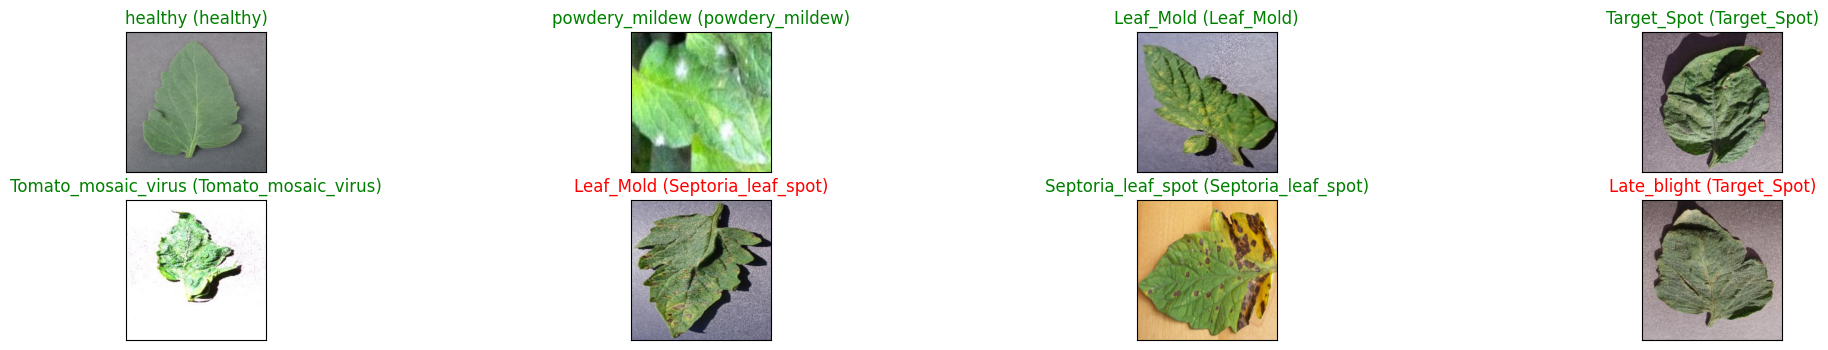

In [36]:
import numpy as np

dataiter = iter(validationloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
model1 = torch.load("/kaggle/working/inceptionV3_tomato.pth")
output, _ = model1(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx] == labels[idx] else "red"))